<a id="toc"></a>
# Advanced Lane Finding

Each code cell below is has a markup cell that preceeds it and provides a title for the code cell.

<a id="chessboard"></a>
## Find Chessboard Corners On A Number Of Calibration Images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

rows = 6
cols = 9
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((rows*cols,3), np.float32)
objp[:,:2] = np.mgrid[0:cols, 0:rows].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (cols,rows), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

print("Chessboard corners detects completed")

Chessboard corners detects completed


<a id="calibrate"></a>
## Calibrate Camera

In [2]:
import pickle
def savePickle(mtx,dist):
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )

img_size = (1280,720)
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
savePickle(mtx,dist)
print("Camer calibration completed")

Camer calibration completed


<a id="testCalibration"></a>
## Test Camera Calibration With Images

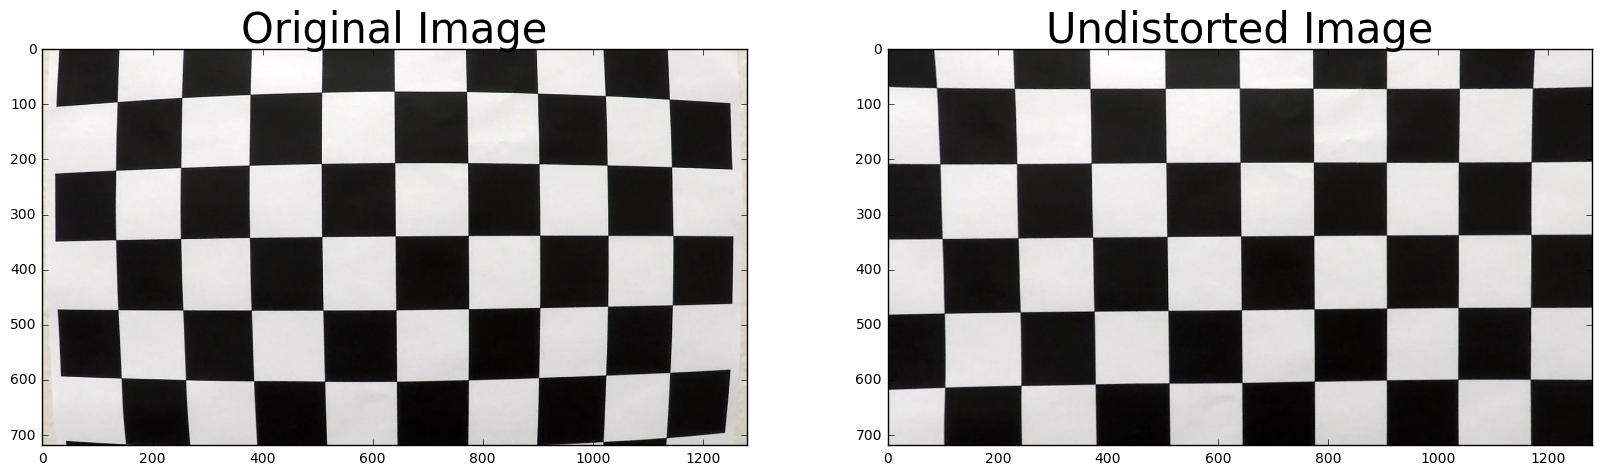

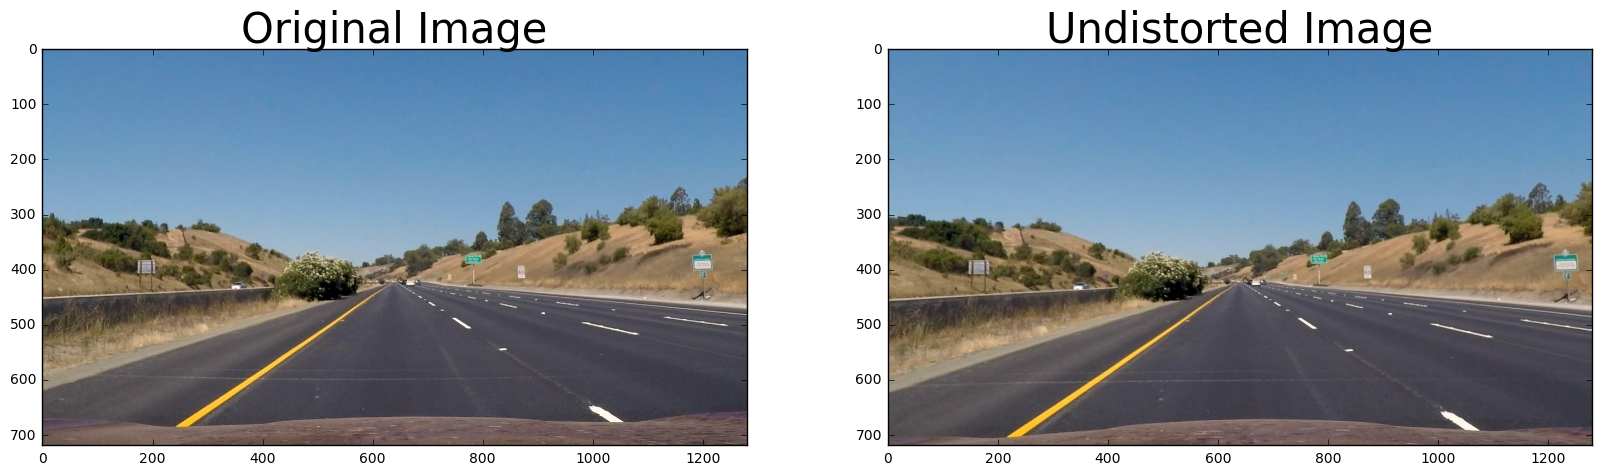

Finished undistorting and showing images


In [3]:
def showImages(ori, dst):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(ori)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.show()

def undistortAndShowImage(file, dist_pickle):
    img = cv2.imread(file)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = cv2.undistort(rgb, mtx, dist, None, mtx)
    showImages(rgb,dst)
    dstf = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
    cv2.imwrite('output_images/' + file.split('/')[1], dstf)
    
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
undistortAndShowImage('camera_cal/calibration1.jpg', dist_pickle);
undistortAndShowImage('test_images/straight_lines1.jpg', dist_pickle);
print("Finished undistorting and showing images")

<a id="thresholds"></a>
## Threshold binary image creating via color transform and gradient

color transfrom and gradient - start


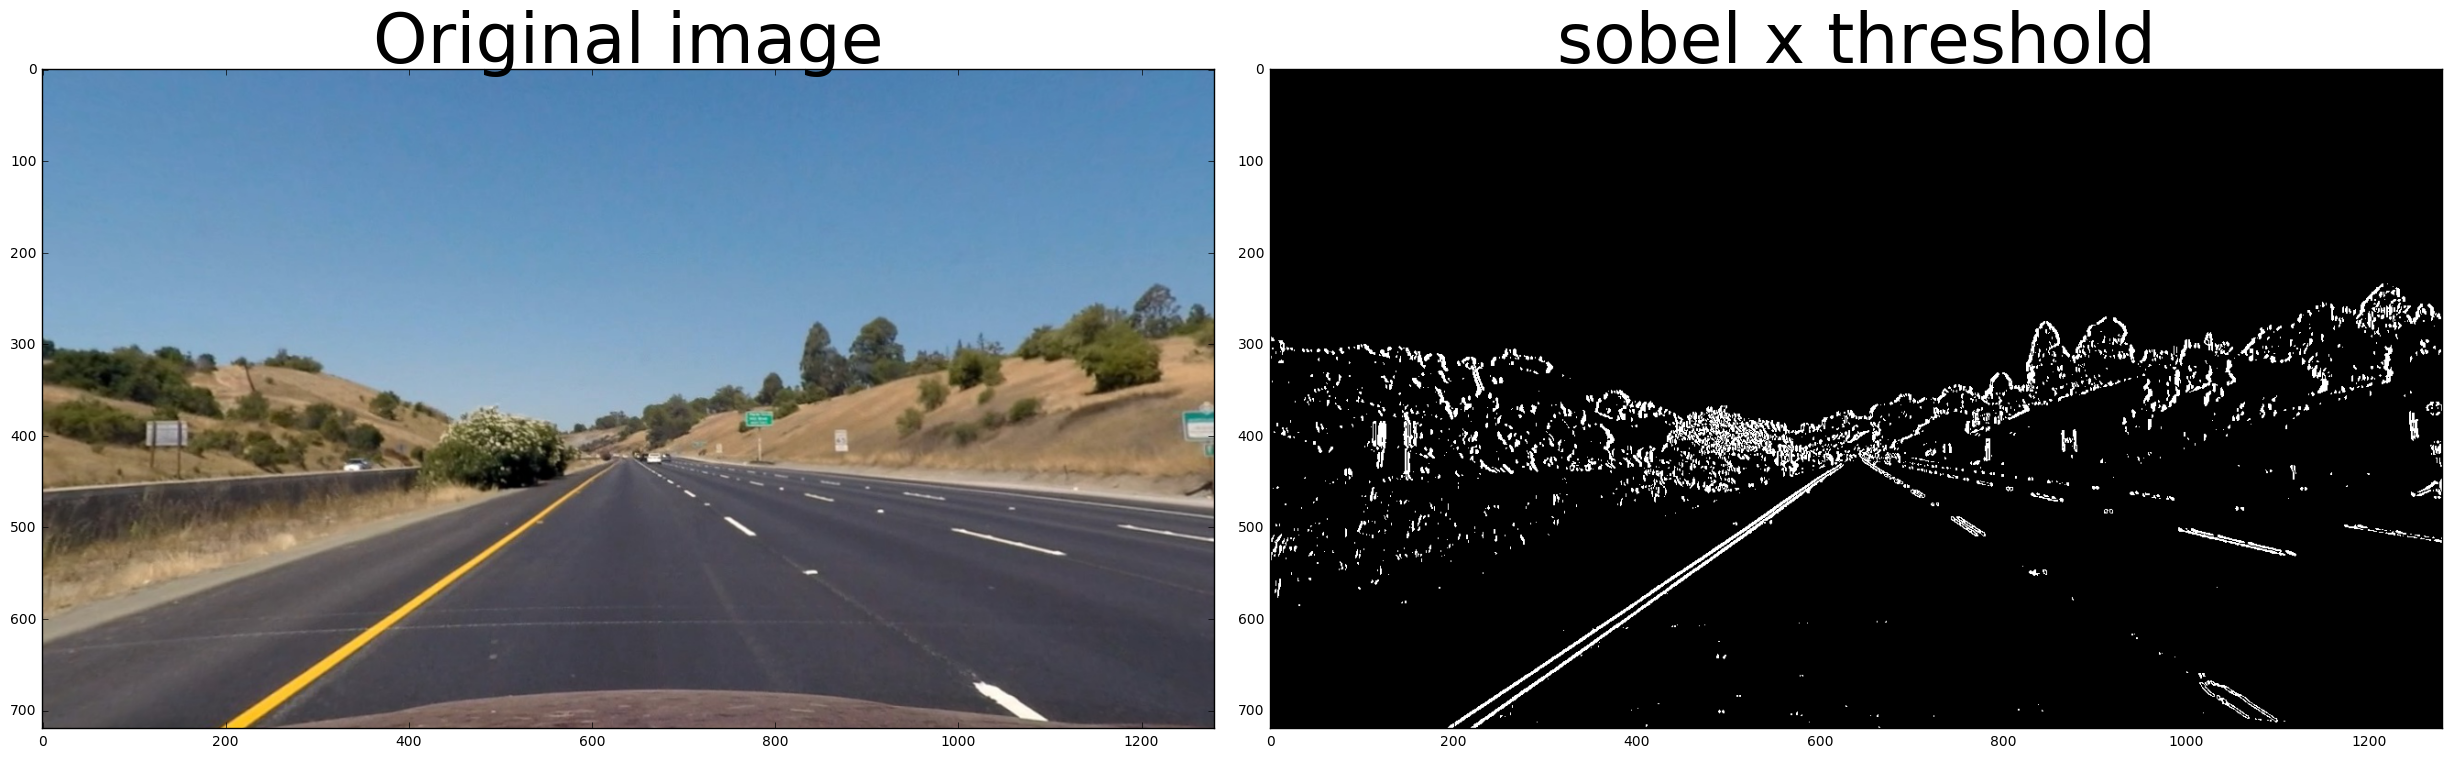

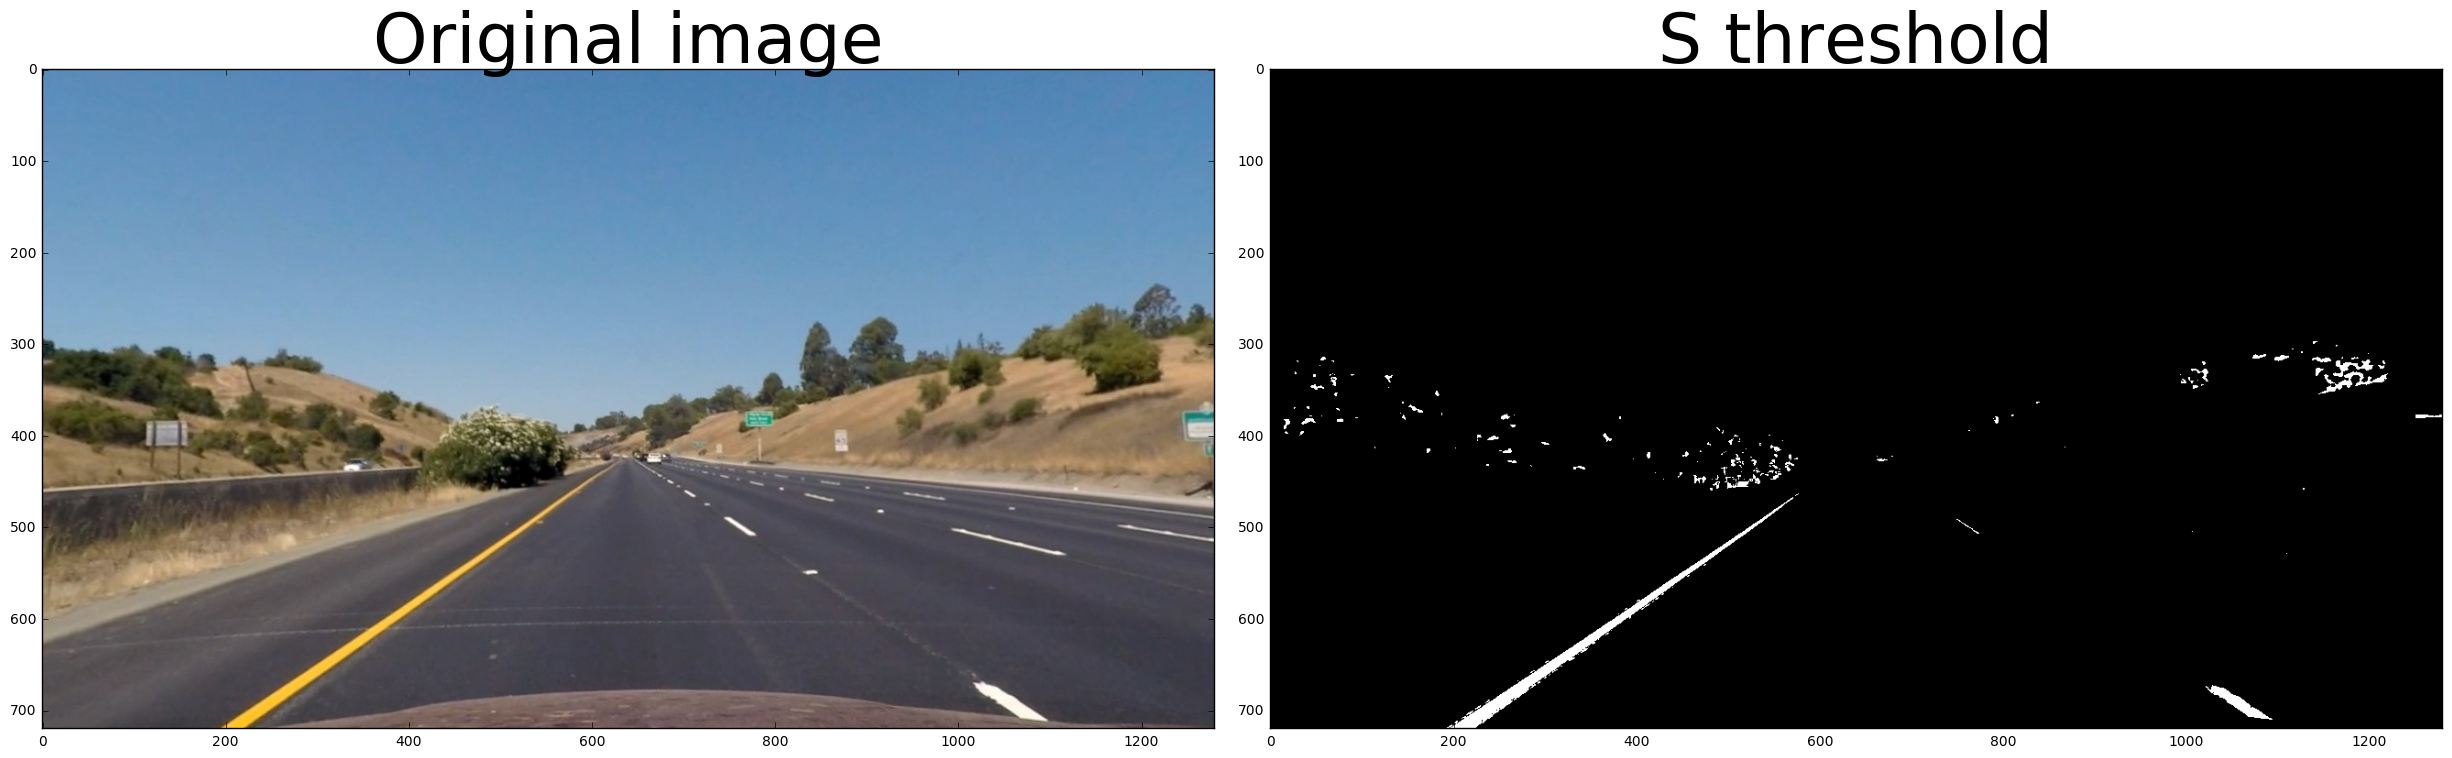

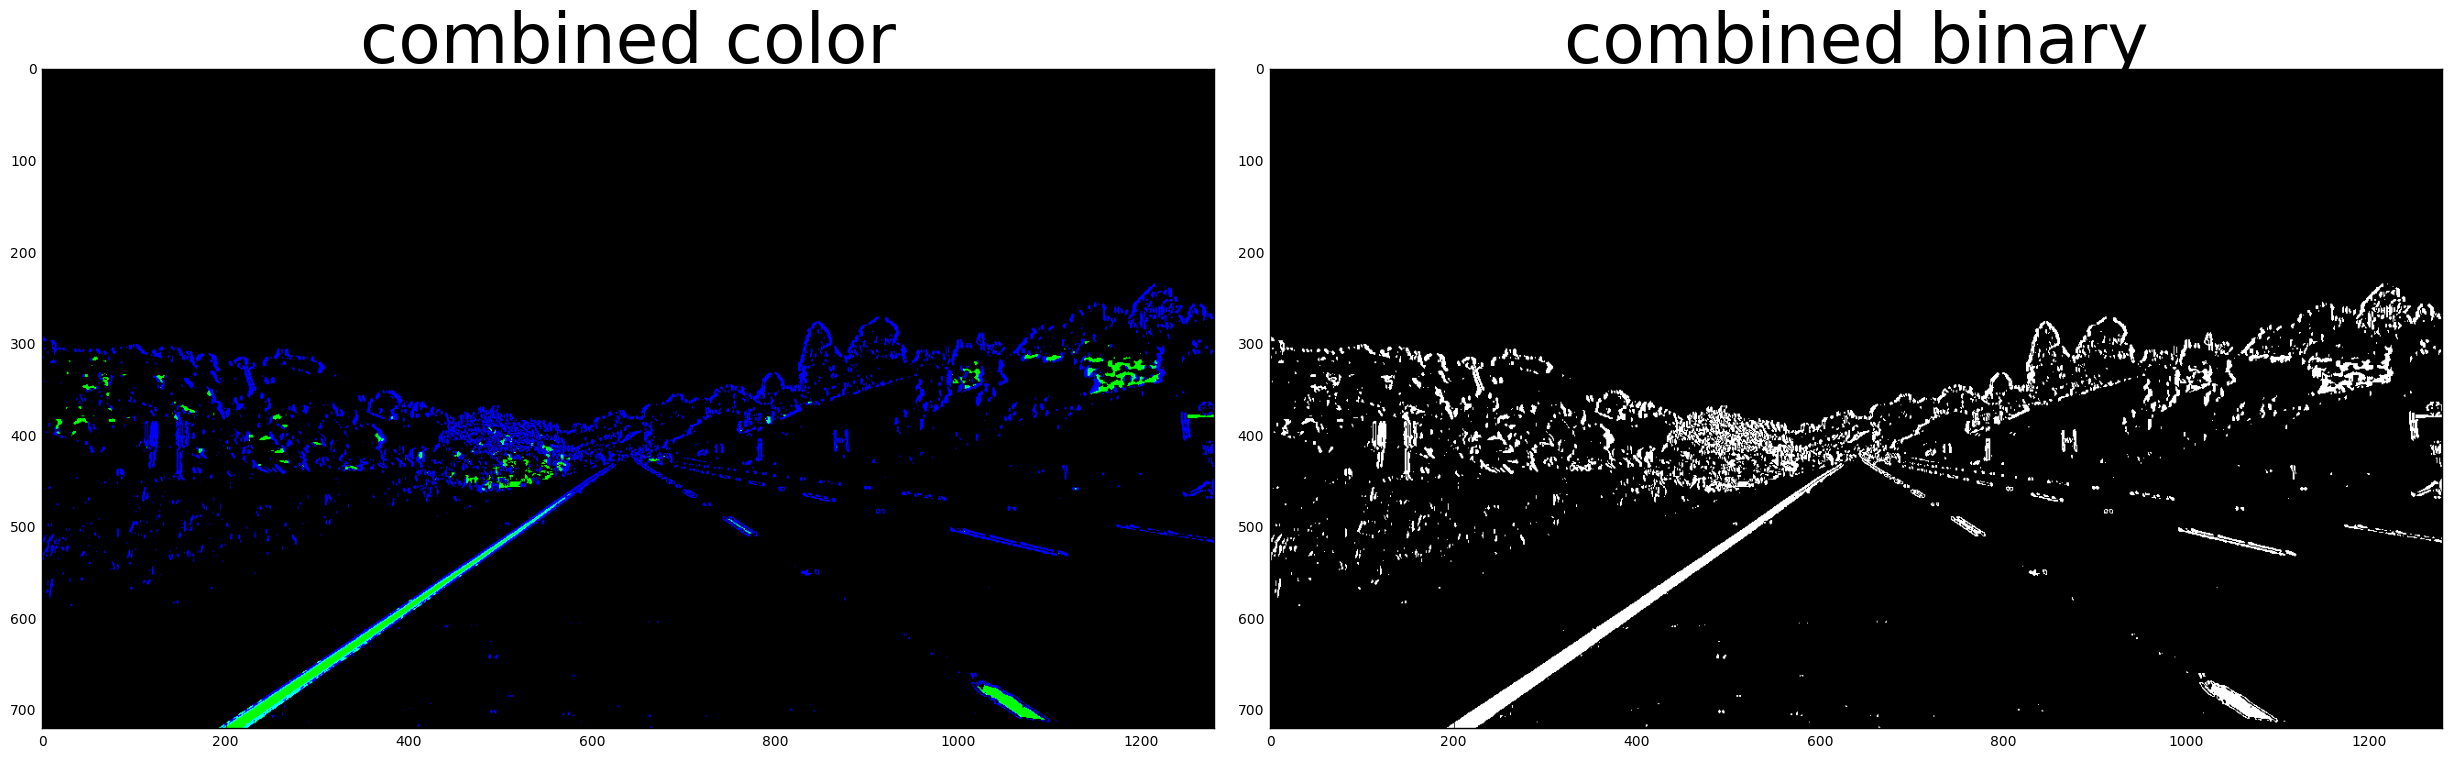

True

In [4]:
print("color transfrom and gradient - start")
def plot(img1, img2, name1, name):
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(name1, fontsize=50)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(name, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show() 

img = cv2.imread('output_images/straight_lines1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
s_channel = hls[:,:,2]

s_thresh_min = 150
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

color_binary = np.dstack((sxbinary, s_binary,  np.zeros_like(sxbinary)))

combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

o = "Original image"
plot(img,sxbinary,o,"sobel x threshold")
plot(img,s_binary,o,"S threshold")
plot(color_binary*255,combined_binary,"combined color","combined binary")

cv2.imwrite('output_images/' + "binary_sobel_x" + ".jpg", cv2.cvtColor(sxbinary*255, cv2.COLOR_GRAY2RGB))
cv2.imwrite('output_images/' + "binary_hls_s" + ".jpg", cv2.cvtColor(s_binary*255, cv2.COLOR_GRAY2RGB))
cv2.imwrite('output_images/' + "binary_sx" + ".jpg", cv2.cvtColor(combined_binary*255, cv2.COLOR_GRAY2RGB))
cv2.imwrite('output_images/' + "binary_sx_color" + ".jpg", color_binary*255)

<a id="perspectiveTransform"></a>
## Perspective Transform

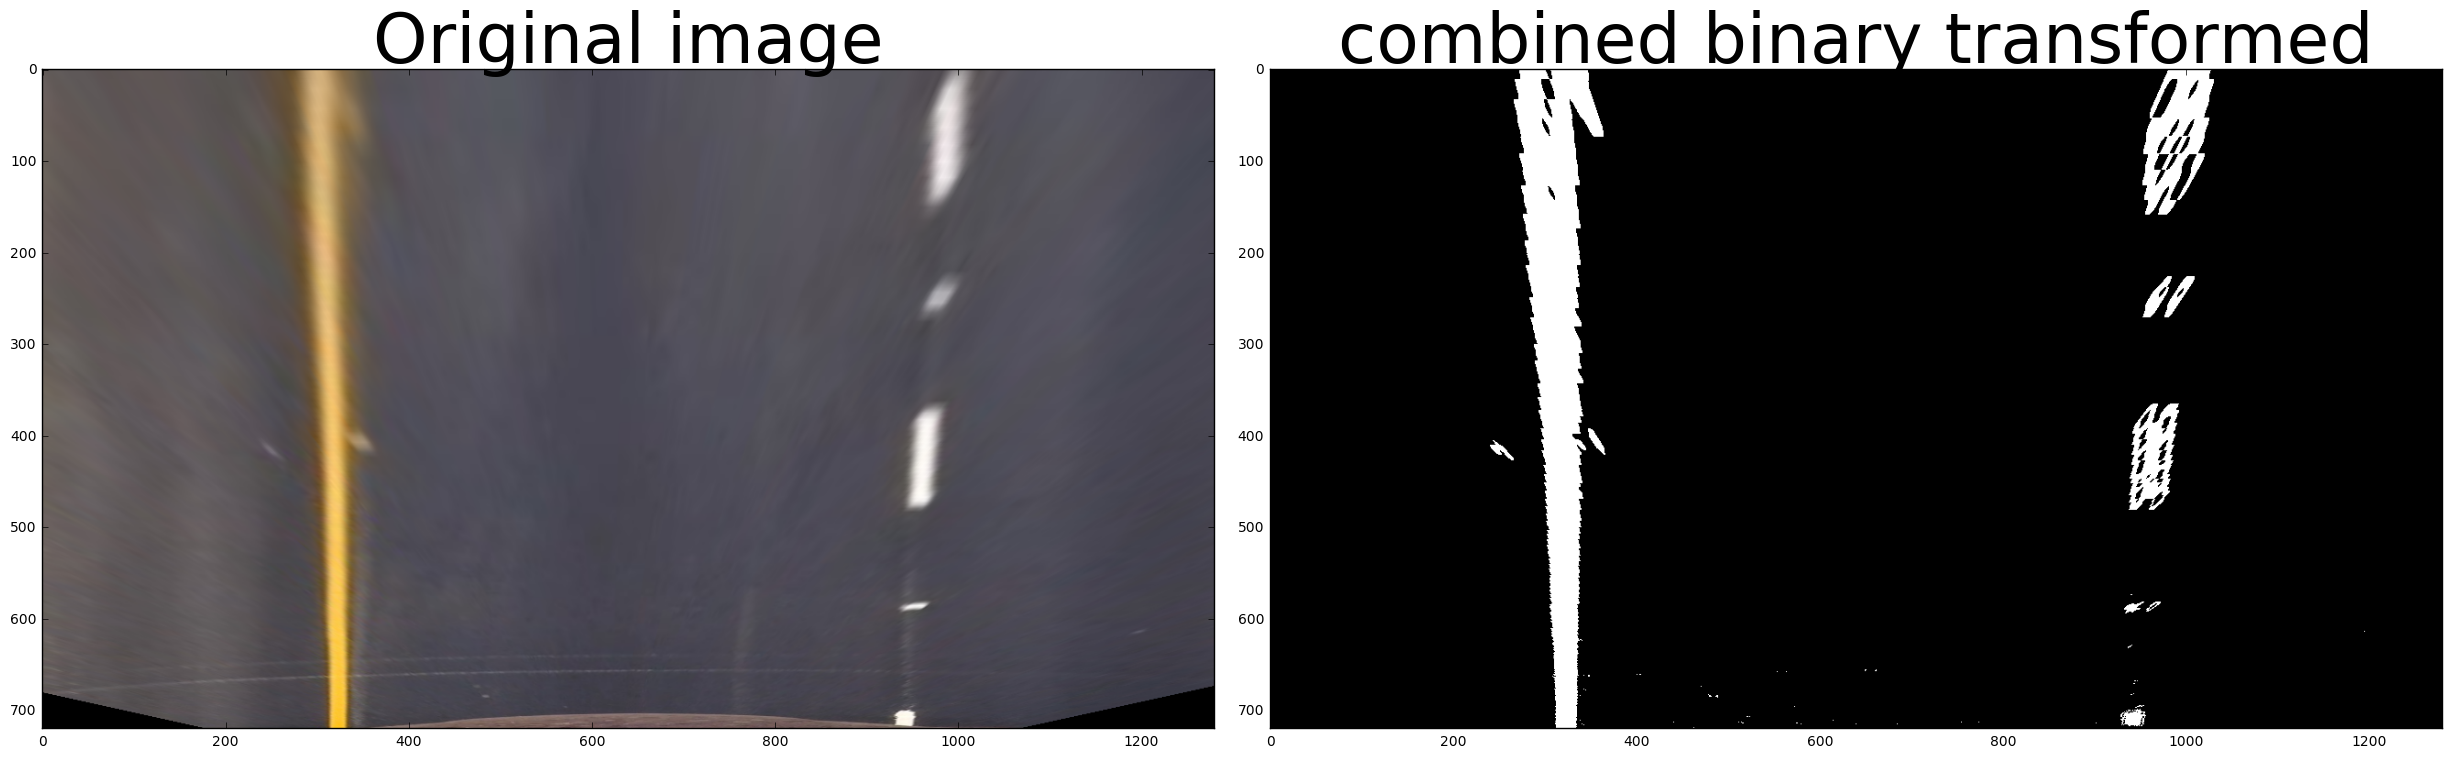

True

In [7]:
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
# Warp the image using OpenCV warpPerspective()
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(combined_binary, M, img_size)
warpedi = cv2.warpPerspective(img, M, img_size)
plot(warpedi,warped,o,"combined binary transformed")
cv2.imwrite('output_images/' + "binary_sx_transform" + ".jpg", cv2.cvtColor(warped*255, cv2.COLOR_GRAY2RGB))
cv2.imwrite('output_images/' + "straight_lines1_transform" + ".jpg", warpedi)

<a id="landLines"></a>
## Identify Lane Lines

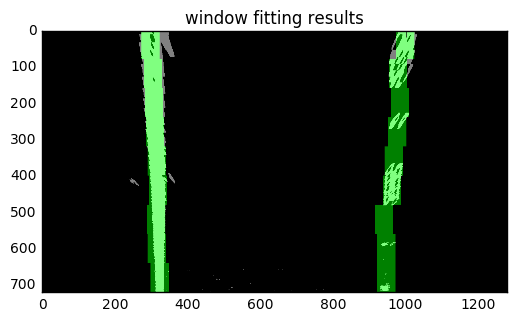

In [14]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped*255,warped*255,warped*255)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 0.5, template, 1, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()
